In [1]:
from __future__ import division
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [156]:
import random
import numpy as np
import pandas as pd
import jgraph
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn import preprocessing
import nltk
import csv
from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import keras
import xgboost as xgb


from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from matplotlib import pyplot as plt
import matplotlib


import datetime
import time

In [6]:
nltk.download('punkt') # for tokenization
nltk.download('stopwords')
stpwds = set(nltk.corpus.stopwords.words("english"))
stemmer = nltk.stem.PorterStemmer()

[nltk_data] Downloading package punkt to /home/yzy/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /home/yzy/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Function Definition

In [7]:
def test_classifier(X_train, X_test, y_train, y_test):

    df_recap= pd.DataFrame(np.zeros((2, 7)),columns=['LogReg', 'NaiveBayes','SVM', 'RandomForest', 'GBM', 'XGBoost', 'NNET'],
                       index = ['F1', 'Accuracy'])


    logit = LogisticRegression()
    naiveb = GaussianNB()
    svm_ = SVC()
    rf = RandomForestClassifier()
    gbm = GradientBoostingClassifier()
    xg = xgb.XGBClassifier(max_depth=5, n_estimators=500, learning_rate=0.05)
    nnet = MLPClassifier()
   
    classifiers= [logit, naiveb,svm_,rf,gbm ,xg, nnet]
    idx=0
    for classifier in classifiers: 
        
        model = classifier.fit(X_train, y_train)
        predictions = model.predict(X_test)    
        f1 = f1_score(y_test, predictions)
        accuracy = accuracy_score(y_test, predictions)
        
        df_recap.iloc[0,idx]=np.round(f1,3)
        df_recap.iloc[1,idx]=np.round(accuracy,3)
        idx+=1
    
    return df_recap

## Load Data

In [8]:
with open("../Data/training_set.txt", "r") as f:
    reader = csv.reader(f)
    training_set  = list(reader)
    
training_set = [element[0].split(" ") for element in training_set]
training_set =  pd.DataFrame(training_set, columns=['NodeSrc', 'NodeDest', 'Edge'])
training_set.head(2)

,NodeSrc,NodeDest,Edge
0,9510123,9502114,1
1,9707075,9604178,1


In [9]:
type(training_set.NodeSrc[0])

str

In [10]:
with open("../Data/node_information.csv", "r") as f:
    reader = csv.reader(f)
    node_info  = list(reader)

IDs = [element[0] for element in node_info]
node_info =  pd.DataFrame(node_info, columns=['ID', 'year_pub', 'title','authors','name_journal','abstract'])
node_info.head(2)

,ID,year_pub,title,authors,name_journal,abstract
0,1001,2000,compactification geometry and duality,Paul S. Aspinwall,,these are notes based on lectures given at tas...
1,1002,2000,domain walls and massive gauged supergravity p...,"M. Cvetic, H. Lu, C.N. Pope",Class.Quant.Grav.,we point out that massive gauged supergravity ...


In [11]:
type(node_info.iloc[0,0])

str

In [12]:
with open("../Data/testing_set.txt", "r") as f:
    reader = csv.reader(f)
    testing_set  = list(reader)

testing_set = [element[0].split(" ") for element in testing_set]
testing_set =  pd.DataFrame(testing_set, columns=['NodeSrc', 'NodeDest'])
testing_set.shape

(32648, 2)

## Pre-processing

In [13]:
# randomly select 5% of training set to fit and validate the models 
# 95% of the remaining graph is used to create the graph features
to_keep = random.sample(range(len(training_set)), k=int(round(len(training_set)*0.05)))
dataset_train_val= training_set.iloc[to_keep]
df_rest = training_set.loc[~training_set.index.isin(to_keep)]

In [14]:
df_rest.shape

(584736, 3)

In [15]:
dataset_train_val.shape

(30776, 3)

In [17]:
nodes = df_rest.loc[df_rest['Edge']=='1']
nodes= nodes[['NodeSrc','NodeDest' ]]
nodes.to_csv('../Data/nodes.txt', sep=' ', index=False, header=False)

In [20]:
import networkx as nx
DG=nx.DiGraph(directed=True)
DG=nx.read_edgelist('../Data/nodes.txt', create_using=nx.DiGraph(), nodetype = str)

In [21]:
neighborsDict={}
for n in DG.nodes():
    neighborsDict[n]= list(DG.neighbors(n))

In [22]:
pr = nx.pagerank(DG, alpha=0.7)

### 1. Training

In [23]:
my_list = list(zip(dataset_train_val.NodeSrc, dataset_train_val.NodeDest))
dict_pairs = pd.Series( my_list , index=dataset_train_val.index).to_dict()

In [24]:
dataset= pd.DataFrame()
dataset['IDPairs']= dict_pairs.keys()
dataset['overlap_title'] = np.zeros(len(dataset))
dataset['overlap_abstract'] = np.zeros(len(dataset))
dataset['temp_diff'] = np.zeros(len(dataset))
dataset['comm_auth'] = np.zeros(len(dataset))
dataset['cossim_a_tfidf'] = np.zeros(len(dataset))
dataset['cossim_t_tfidf'] = np.zeros(len(dataset))
dataset['lsa_abstract'] = np.zeros(len(dataset))
dataset['lsa_title'] = np.zeros(len(dataset))
dataset['nb_cit_indiv'] = np.zeros(len(dataset)) 

dataset['common_out_neighbors'] = np.zeros(len(dataset))
dataset['common_in_neighbors'] = np.zeros(len(dataset))
dataset['jaccard_sim_out'] = np.zeros(len(dataset))
dataset['jaccard_sim_in'] = np.zeros(len(dataset))
dataset['shortest_path'] = np.zeros(len(dataset))
dataset['page_rank'] = np.zeros(len(dataset))
dataset['node2vec']   = np.zeros(len(dataset))


dataset.head(2)

,IDPairs,overlap_title,overlap_abstract,temp_diff,comm_auth,cossim_a_tfidf,cossim_t_tfidf,lsa_abstract,lsa_title,nb_cit_indiv,common_out_neighbors,common_in_neighbors,jaccard_sim_out,jaccard_sim_in,shortest_path,page_rank,node2vec
0,545917,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,162541,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
temp = pd.DataFrame.from_dict(dict_pairs, orient='index', columns=['NodeSrc','NodeDest'])
temp['IDPairs']=dict_pairs.keys()
dataset_train_val['IDPairs']=dataset_train_val.index
df_merg=pd.merge(dataset_train_val, temp, on=['IDPairs'])
df_merg=df_merg[['IDPairs','Edge']]

In [35]:
dataset=pd.merge(dataset,df_merg, on='IDPairs')
dataset.head(1)

,IDPairs,overlap_title,overlap_abstract,temp_diff,comm_auth,cossim_a_tfidf,cossim_t_tfidf,lsa_abstract,lsa_title,nb_cit_indiv,common_out_neighbors,common_in_neighbors,jaccard_sim_out,jaccard_sim_in,shortest_path,page_rank,node2vec,Edge
0,545917,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


### 2. Test

In [37]:
my_list_test = list(zip(testing_set.NodeSrc, testing_set.NodeDest))
dict_pairs_test = pd.Series(my_list_test, index=testing_set.index).to_dict()

In [38]:
dataset_test= pd.DataFrame()
dataset_test['IDPairs']= dict_pairs_test.keys()
dataset_test['overlap_title'] = np.zeros(len(dataset_test))
dataset_test['overlap_abstract'] = np.zeros(len(dataset_test))
dataset_test['temp_diff'] = np.zeros(len(dataset_test))
dataset_test['overlap_title'] = np.zeros(len(dataset_test))
dataset_test['comm_auth'] = np.zeros(len(dataset_test))


dataset_test['overlap_title'] = np.zeros(len(dataset_test))
dataset_test['overlap_abstract'] = np.zeros(len(dataset_test))
dataset_test['temp_diff'] = np.zeros(len(dataset_test))
dataset_test['comm_auth'] = np.zeros(len(dataset_test))
dataset_test['cossim_a_tfidf'] = np.zeros(len(dataset_test))
dataset_test['cossim_t_tfidf'] = np.zeros(len(dataset_test))
dataset_test['lsa_abstract'] = np.zeros(len(dataset_test))
dataset_test['lsa_title'] = np.zeros(len(dataset_test))
dataset_test['nb_cit_indiv'] = np.zeros(len(dataset_test)) 

dataset_test['common_out_neighbors'] = np.zeros(len(dataset_test))
dataset_test['common_in_neighbors'] = np.zeros(len(dataset_test))
dataset_test['jaccard_sim_out'] = np.zeros(len(dataset_test))
dataset_test['jaccard_sim_in'] = np.zeros(len(dataset_test))
dataset_test['shortest_path'] = np.zeros(len(dataset_test))
dataset_test['page_rank'] = np.zeros(len(dataset_test))
dataset_test['node2vec']   = np.zeros(len(dataset_test))

dataset_test.head(2)

,IDPairs,overlap_title,overlap_abstract,temp_diff,comm_auth,cossim_a_tfidf,cossim_t_tfidf,lsa_abstract,lsa_title,nb_cit_indiv,common_out_neighbors,common_in_neighbors,jaccard_sim_out,jaccard_sim_in,shortest_path,page_rank,node2vec
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Feature Engineering
---
### A. Text-Based Features
#### 1. Number of overlapping words in the title

In [39]:
def overlap_title(idPair, dict_pairs):
    source = dict_pairs.get(idPair)[0]
    target = dict_pairs.get(idPair)[1] 
    
    source_info = node_info.loc [node_info['ID']==source]
    target_info = node_info.loc [node_info['ID']==target]
    
    #Title
    source_title = source_info.iloc[0,2].lower().split(" ")   
    source_title = [token for token in source_title if token not in stpwds]
    source_title = [stemmer.stem(token) for token in source_title]
      
    target_title = source_info.iloc[0,2].lower().split(" ")
    target_title = [token for token in target_title if token not in stpwds]
    target_title = [stemmer.stem(token) for token in target_title]
    
    return (len(set(source_title).intersection(set(target_title))))

In [59]:
time_beg = datetime.datetime.now()
dataset['overlap_title']=list(map(lambda i: overlap_title(i,dict_pairs), dataset['IDPairs']))
time_end = datetime.datetime.now()
print (time_end-time_beg)

0:01:42.456253


In [60]:
time_beg = datetime.datetime.now()
dataset_test['overlap_title']=list(map(lambda i: overlap_title(i,dict_pairs_test), dataset_test['IDPairs']))
time_end = datetime.datetime.now()
print (time_end-time_beg)

0:01:48.417946


#### 2. Number of overlapping words in the abstract

In [42]:
def overlap_abstract(idPair,dict_pairs):
    source = dict_pairs.get(idPair)[0]
    target = dict_pairs.get(idPair)[1] 
    
    source_info = node_info.loc [node_info['ID']==source]
    target_info = node_info.loc [node_info['ID']==target]
    
    #Title
    source_abstract = source_info.iloc[0,5].lower().split(" ")   
    source_abstract = [token for token in source_abstract if token not in stpwds]
    source_abstract = [stemmer.stem(token) for token in source_abstract]
      
    target_abstract = source_info.iloc[0,5].lower().split(" ")
    target_abstract = [token for token in target_abstract if token not in stpwds]
    target_abstract = [stemmer.stem(token) for token in target_abstract]
    
    return (len(set(source_abstract).intersection(set(target_abstract))))

In [68]:
time_beg = datetime.datetime.now()
dataset['overlap_abstract']=list(map(lambda i: overlap_abstract(i,dict_pairs), dataset['IDPairs']))
time_end = datetime.datetime.now()
print (time_end-time_beg)

0:02:30.343376


In [69]:
time_beg = datetime.datetime.now()
dataset_test['overlap_abstract']=list(map(lambda i: overlap_abstract(i,dict_pairs_test), dataset_test['IDPairs']))
time_end = datetime.datetime.now()
print (time_end-time_beg)

0:02:39.929490


#### 3. Temporal distance between the papers

In [44]:
def tmp_dist(idPair,dict_pairs):
    source = dict_pairs.get(idPair)[0]
    target = dict_pairs.get(idPair)[1] 
    
    source_info = node_info.loc [node_info['ID']==source]
    target_info = node_info.loc [node_info['ID']==target]
    
    #Year
    source_year = source_info.iloc[0,1]
    target_year = target_info.iloc[0,1]
 
    return (int(source_year) - int(target_year))

In [61]:
time_beg = datetime.datetime.now()
dataset['temp_diff']=list(map(lambda i: tmp_dist(i,dict_pairs), dataset['IDPairs']))
time_end = datetime.datetime.now()
print (time_end-time_beg)

0:01:39.238520


In [62]:
time_beg = datetime.datetime.now()
dataset_test['temp_diff']=list(map(lambda i: tmp_dist(i, dict_pairs_test), dataset_test['IDPairs']))
time_end = datetime.datetime.now()
print (time_end-time_beg)

0:01:44.324960


#### 4. Number of common authors

In [65]:
def comm_auth(idPair, dict_pairs):
    source = dict_pairs.get(idPair)[0]
    target = dict_pairs.get(idPair)[1] 
    
    source_info = node_info.loc [node_info['ID']==source]
    target_info = node_info.loc [node_info['ID']==target]
    
    #Authors
    source_auth = source_info.iloc[0,3].split(",")
    target_auth = target_info.iloc[0,3].split(",")
 
    return (len(set(source_auth).intersection(set(target_auth))))

In [ ]:
time_beg = datetime.datetime.now()
dataset['comm_auth']=list(map(lambda i: comm_auth(i,dict_pairs), dataset['IDPairs']))
time_end = datetime.datetime.now()
print (time_end-time_beg)

In [ ]:
time_beg = datetime.datetime.now()
dataset_test['comm_auth']=list(map(lambda i: comm_auth(i, dict_pairs_test), dataset_test['IDPairs']))
time_end = datetime.datetime.now()
print (time_end-time_beg)

In [70]:
dataset.head(2)

,IDPairs,overlap_title,overlap_abstract,temp_diff,comm_auth,cossim_a_tfidf,cossim_t_tfidf,lsa_abstract,lsa_title,nb_cit_indiv,common_out_neighbors,common_in_neighbors,jaccard_sim_out,jaccard_sim_in,shortest_path,page_rank,node2vec,Edge
0,545917,4,50,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,162541,9,26,-5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


---
### Test classifiers

In [72]:
col= ['IDPairs','Edge']
colnames=[i for i in dataset.columns if i not in col]
X = dataset[colnames]

print("Features : %s"% list(X))

y = dataset['Edge']
y= list(map (lambda i: int(i), y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
test_classifier(X_train, X_test, y_train, y_test)

Features : ['overlap_title', 'overlap_abstract', 'temp_diff', 'comm_auth', 'cossim_a_tfidf', 'cossim_t_tfidf', 'lsa_abstract', 'lsa_title', 'nb_cit_indiv', 'common_out_neighbors', 'common_in_neighbors', 'jaccard_sim_out', 'jaccard_sim_in', 'shortest_path', 'page_rank', 'node2vec']


,LogReg,NaiveBayes,SVM,RandomForest,GBM,XGBoost,NNET
F1,0.732,0.807,0.804,0.759,0.809,0.806,0.808
Accuracy,0.680,0.756,0.753,0.721,0.763,0.762,0.762


---
### B. Cosine distance - TF-IDF
#### 1. Cosine distance between two TF-IDF abstracts

In [74]:
import gensim
from gensim import corpora
from gensim.models import TfidfModel
from gensim.models import LsiModel
from gensim.similarities import MatrixSimilarity

In [75]:
raw_documents = list(node_info['abstract'])

from nltk.tokenize import word_tokenize
gen_docs = [[w.lower() for w in word_tokenize(text)] 
            for text in raw_documents]

In [79]:
# Creation of dictionary, corpus and TF-IDF model
dictionary = gensim.corpora.Dictionary(gen_docs)
corpus = [dictionary.doc2bow(gen_doc) for gen_doc in gen_docs]
tf_idf = gensim.models.TfidfModel(corpus)

In [80]:
def cossim_title(ID,dict_pairs,node_info,dictionary,tf_idf):
    
    doc1=node_info.loc[node_info['ID']==dict_pairs[ID][0],'title'].values[0]
    doc2=node_info.loc[node_info['ID']==dict_pairs[ID][1],'title'].values[0]

    idx_doc1=node_info.loc[node_info['ID']==dict_pairs[ID][0],'title'].index[0]
    idx_doc2=node_info.loc[node_info['ID']==dict_pairs[ID][1],'title'].index[0]
    
    vec_bow1 = dictionary.doc2bow(doc1.lower().split())
    vec_bow2 = dictionary.doc2bow(doc2.lower().split())

    return gensim.matutils.cossim(tf_idf[vec_bow1], tf_idf[vec_bow2])

In [82]:
start_time=time.time()
dataset['cossim_t_tfidf']=np.zeros(len(dataset))
dataset['cossim_t_tfidf']=list(map(lambda i: cossim_title(i,dict_pairs,node_info,dictionary,tf_idf), dataset['IDPairs']))
print("--- %s minutes ---" % (np.float(time.time() - start_time)/60))

--- 3.0505210359891257 minutes ---


In [83]:
start_time=time.time()
dataset_test['cossim_t_tfidf']=np.zeros(len(dataset_test))
dataset_test['cossim_t_tfidf']=list(map(lambda i: cossim_title(i,dict_pairs_test,node_info,dictionary,tf_idf), dataset_test['IDPairs']))
print("--- %s minutes ---" % (np.float(time.time() - start_time)/60))

--- 3.2379275719324747 minutes ---


---
### Test classifiers

In [84]:
col= ['IDPairs','Edge']
colnames=[i for i in dataset.columns if i not in col]
X = dataset[colnames]

print("Features : %s"% list(X))

y = dataset['Edge']
y= list(map (lambda i: int(i), y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
test_classifier(X_train, X_test, y_train, y_test)

Features : ['overlap_title', 'overlap_abstract', 'temp_diff', 'comm_auth', 'cossim_a_tfidf', 'cossim_t_tfidf', 'lsa_abstract', 'lsa_title', 'nb_cit_indiv', 'common_out_neighbors', 'common_in_neighbors', 'jaccard_sim_out', 'jaccard_sim_in', 'shortest_path', 'page_rank', 'node2vec']


,LogReg,NaiveBayes,SVM,RandomForest,GBM,XGBoost,NNET
F1,0.678,0.522,0.808,0.761,0.814,0.812,0.801
Accuracy,0.665,0.638,0.761,0.738,0.780,0.778,0.770


---
### C. Latent Semantic Analysis

In [85]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer

#### 1. The cosine distance between two LSA abstracts

In [86]:
# compute TFIDF vector of each paper
corpus = set(node_info['abstract'])
vectorizer = TfidfVectorizer(stop_words="english")
features_TFIDF = vectorizer.fit_transform(corpus)

In [92]:
# Fit LSA. Use algorithm = “randomized” for large datasets 
lsa = TruncatedSVD(100, algorithm = 'arpack')
dtm_lsa = lsa.fit_transform(features_TFIDF)
dtm_lsa = Normalizer(copy=False).fit_transform(dtm_lsa)

In [93]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(dtm_lsa) * np.asmatrix(dtm_lsa).T) 
save= pd.DataFrame(similarity,index=corpus, columns=corpus)
save.head(1)

,some relationships between string theories and eleven-dimensional supergravity are discussed and reviewed we see how some relationships can be derived from others the cases of n 2 supersymmetry in nine dimensions and n 4 supersymmetry in four dimensions are discussed in some detail the latter case leads to consideration of quotients of a k3 surface times a torus and to a possible peculiar relationship between eleven-dimensional supergravity and the heterotic strings in ten dimensions lecture given at s-duality and mirror symmetry trieste june 1995,dimensions paper also at using strong-coupling quantum field theory we calculate highly accurate critical exponents nu eta from new seven-loop expansions in three dimensions our theoretical value for the critical exponent alpha of the specific heat near the lambda-point of superfluid helium is alpha 0 01294 0 00060 in excellent agreement with the space shuttle experimental value alpha 0 01285 0 00038,approximations made no essential changes in results a variant of an earlier proposal by the author and sengupta to describe four dimensional maxwell electrodynamics in einstein-cartan spacetimes through a kalb-ramond field as an intermediary is shown to lead to a new maxwell-kalb-ramond coupling that violates spatial parity even when the kr gauge field has its standard parity assignment one consequence of this coupling seems to be a modulation independent of wavelength but dependent on the kr field strength of the intensity of synchrotron radiation observed from distant galactic sources,phys lett b we study the constraints on models with extra dimensions arising from local anomaly cancellation we consider a five-dimensional field theory with a u 1 gauge field and a charged fermion compactified on the orbifold s 1 z 2 x z 2 we show that even if the orbifold projections remove both fermionic zero modes there are gauge anomalies localized at the fixed points anomalies naively cancel after integration over the fifth dimension but gauge invariance is broken spoiling the consistency of the theory we discuss the implications for realistic supersymmetric models with a single higgs hypermultiplet in the bulk and possible cancellation mechanisms in non-minimal models,after presenting a survey of theoretical results concerning the structure of two-dimensional qcd we present a numerical study related to the mass eigenstates and the decay amplitudes of higher mesonic states we discuss in detail the fate of important dynamical points such as stability of the spectrum and the problem of screening versus confinement in this context we point out differences in the large distance behaviour of the potential which can be responsible for the question of stability of the spectrum as well as whether it is finite,we provide a new class of exactly solvable superconformal field theories that corresponds to type ii compactification on manifolds with exceptional holonomies we combine n 1 liouville field and n 1 coset models and construct modular invariant partition functions of strings moving on these manifolds the resulting theories preserve spacetime supersymmetry also we explicitly construct chiral currents in these models to realize consistent string theories,we compute the o 1 n correction to the stability critical exponent omega in the landau-ginzburg-wilson model with o n x o m symmetry at the stable chiral fixed point and the stable direction at the unstable antichiral fixed point several constraints on the o 1 n coefficients of the four loop perturbative beta-functions are computed,in these lectures we present a detailed description of various aspects of gauge theories with extended n 2 and n 4 supersymmetry that are at the basis of recently found exact results these results include the exact calculation of the low energy effective action for the light degrees of freedom in the n 2 super yang-mills theory and the conjecture supported by some checks that the n 4 super yang-mills theory is dual in the sense

In [94]:
def cosdist_lsa_abstract(ID,dict_pairs ):    
    abstract1=node_info.loc[node_info['ID']==dict_pairs[ID][0],'abstract'].values[0]
    abstract2=node_info.loc[node_info['ID']==dict_pairs[ID][1],'abstract'].values[0]        
    return save.loc[abstract1][abstract2]
    ataset['lsa_abstract']=np.zeros(len(dataset))

In [95]:
time_beg = datetime.datetime.now()
dataset['lsa_abstract']=list(map(lambda i: cosdist_lsa_abstract(i, dict_pairs), dataset['IDPairs']))
time_end = datetime.datetime.now()
print (time_end-time_beg)

0:01:32.294846


In [96]:
time_beg = datetime.datetime.now()
dataset_test['lsa_abstract']=list(map(lambda i: cosdist_lsa_abstract(i, dict_pairs_test), dataset_test['IDPairs']))
time_end = datetime.datetime.now()
print (time_end-time_beg)

0:01:37.734152


#### 2. The cosine distance between two LSA titles

In [97]:
# compute TFIDF vector of each paper
corpus = set(node_info['title'])
vectorizer = TfidfVectorizer(stop_words="english")
features_TFIDF = vectorizer.fit_transform(corpus)

In [98]:
# Fit LSA. Use algorithm = “randomized” for large datasets 
lsa = TruncatedSVD(100, algorithm = 'arpack')
dtm_lsa = lsa.fit_transform(features_TFIDF)
dtm_lsa = Normalizer(copy=False).fit_transform(dtm_lsa)

In [99]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(dtm_lsa) * np.asmatrix(dtm_lsa).T) 
save= pd.DataFrame(similarity,index=corpus, columns=corpus)
save.head(2)

,domain walls without cosmological constant in higher order gravity,nonlinear supersymmetry in quantum mechanics,some new non-abelian 2d dualities,a geometrical interpretation of classical w-transformations,a comparison of the proper time equation and the renormalization group,solutions to the quantum yang-baxter equation with extra non-additive,on fractional instanton numbers in six dimensional heterotic e8 x e8,on the holographic rg-flow and the low-energy strong coupling large n,diffeomorphism invariant integrable field theories and hypersurface,comments on brane configurations with semi-infinite d4 branes,...,spectral geometry and quantum gravity,d 10 n iib supergravity,on the random vector potential model in two dimensions,on variants of the c m 2 c m 3 c ncg model of elementary,global properties of exact solutions in integrable dilaton-gravity,superstring phenomenology a personal perspective,quantum cohomology at higher genus,two-point functions in affine current algebra and conjugate weights,quantum corrections to the reissner-nordstr o m and kerr-newman,some issues in conformal field theory with boundaries and crosscaps
domain walls without cosmological constant in higher order gravity,1.000000,0.013302,0.008610,-0.007771,0.001851,0.013159,-0.021530,0.055009,-0.007260,-0.022809,...,0.179208,-0.016993,-0.018937,-0.008751,0.120501,0.030817,0.319562,0.009707,0.033538,0.000108
nonlinear supersymmetry in quantum mechanics,0.013302,1.000000,0.006117,0.034847,0.020582,0.175831,0.031305,0.014421,-0.002991,-0.009431,...,0.206995,-0.016607,-0.003897,-0.001776,0.006100,-0.020268,0.236401,-0.012665,0.342513,0.004469


In [100]:
def cosdist_lsa_title(ID, dict_pairs):    
    title1=node_info.loc[node_info['ID']==dict_pairs[ID][0],'title'].values[0]
    title2=node_info.loc[node_info['ID']==dict_pairs[ID][1],'title'].values[0]        
    return save.loc[title1][title2]

In [101]:
time_beg = datetime.datetime.now()
dataset['lsa_title']=list(map(lambda i: cosdist_lsa_title(i, dict_pairs), dataset['IDPairs']))
time_end = datetime.datetime.now()
print (time_end-time_beg)

0:01:32.142900


In [102]:
time_beg = datetime.datetime.now()
dataset_test['lsa_title']=list(map(lambda i: cosdist_lsa_title(i, dict_pairs_test), dataset_test['IDPairs']))
time_end = datetime.datetime.now()
print (time_end-time_beg)

0:01:37.753813


---
### Test the classifiers

In [105]:
col= ['IDPairs','Edge']
colnames=[i for i in dataset.columns if i not in col]
X = dataset[colnames]

print("Features : %s"% list(X))

y = dataset['Edge']
y= list(map (lambda i: int(i), y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
test_classifier(X_train, X_test, y_train, y_test)

Features : ['overlap_title', 'overlap_abstract', 'temp_diff', 'comm_auth', 'cossim_a_tfidf', 'cossim_t_tfidf', 'lsa_abstract', 'lsa_title', 'nb_cit_indiv', 'common_out_neighbors', 'common_in_neighbors', 'jaccard_sim_out', 'jaccard_sim_in', 'shortest_path', 'page_rank', 'node2vec']


,LogReg,NaiveBayes,SVM,RandomForest,GBM,XGBoost,NNET
F1,0.850,0.769,0.852,0.867,0.884,0.884,0.883
Accuracy,0.841,0.785,0.834,0.858,0.875,0.874,0.874


---
### D. Graph Based Features
#### 1. Number of citations between authors
Count authors individually + normalization according to the number of combinations of pairs between 2 groups of authors

In [106]:
#Build the dictionary 
start_time=time.time()

auth1=[]
auth2=[]

auth1=[node_info.loc[node_info['ID']== idnode, 'authors'].values[0] for idnode in nodes.NodeSrc]
auth2=[node_info.loc[node_info['ID']== idnode, 'authors'].values[0] for idnode in nodes.NodeDest]


auth1_s = list(map(lambda i: auth1[i].split(','), range(len(auth1))))
auth1_s[0]= [element for element in auth1_s[0] if len(element)>2]

auth2_s = list(map(lambda i: auth2[i].split(','), range(len(auth2))))
auth2_s[0]= [element for element in auth2_s[0] if len(element)>2]


auth = list(zip(auth1_s, auth2_s, dict_pairs.keys()))


import itertools
temp=list(map(lambda i: list(itertools.product(auth[i][0],auth[i][1])), range(len(auth))))
temp=list(itertools.chain.from_iterable(temp))

auth_counter=dict(Counter([i for i in temp]))
print ('%s second' % (time.time()-start_time))

TypeError: unsupported operand type(s) for /: 'str' and 'int'

In [108]:
start_time=time.time()

auth1=[node_info.loc[node_info['ID']==dict_pairs[i][0],'authors'].values[0] for i in dict_pairs.keys()]
auth2=[node_info.loc[node_info['ID']==dict_pairs[i][1],'authors'].values[0] for i in dict_pairs.keys()]

auth1_s = list(map(lambda i: auth1[i].split(','), range(len(auth1))))
auth2_s = list(map(lambda i: auth2[i].split(','), range(len(auth2))))
auth = list(zip(auth1_s, auth2_s, dict_pairs.keys()))

print('step 0')
final_auth_indiv=[]
for a in auth:
    print('step 1')
    c = 0
    for b in list(itertools.product(a[0],a[1])):
         if b in auth_counter.keys():
            print(b)
            c = c + auth_counter[b]
    final_auth_indiv.append((a[2],c/len(list(itertools.product(a[0],a[1])))))
      
final_auth_indiv=pd.DataFrame(final_auth_indiv,columns=['IDPairs','nb_cit_indiv'])
dataset['nb_cit_indiv']=final_auth_indiv['nb_cit_indiv']

print ('%s seconds' % (time.time()-start_time))

step 0
step 1
step 1
step 1
step 1
(' ', ' huber')
(' ', ' S. Theisen')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('', 'John H. Schwarz')
('', ' Ashoke Sen')
step 1
step 1
(' Arkady A. Tseytlin', ' A.A. Tseytlin')
step 1
step 1
step 1
('', 'M. R. Rahimi Tabar')
('', ' S. Rouhani')
step 1
step 1
step 1
('', 'Paolo Aschieri')
step 1
step 1
('', 'S. Elitzur')
('', ' A. Giveon')
('', ' D. Kutasov')
('', ' E. Rabinovici')
step 1
step 1
('', ' ')
step 1
('', 'Jan O. Conrad')
step 1
('James P. Gregory', ' ')
step 1
(' Nemanja Kaloper', ' ')
step 1
step 1
step 1
('', '')
step 1
('', 'Klaus Behrndt')
('', ' Bert Janssen')
step 1
step 1
step 1
step 1
('O. Aharony', '')
(' M. Berkooz', '')
(' S. Kachru', '')
(' N. Seiberg', '')
(' ', '')
(' E. Silverstein', '')
step 1
step 1
('Frederic Leblond', ' ')
(' Am', ' ')
(' a W. Peet', ' ')
step 1
step 1
step 1
step 1
step 1
('', '')
step 1
('Andreas Recknagel', '')
(' Volker Schomerus', '')
step 1
step 1
step 1
step 1
step 1
(' ', 'A. Stro

In [109]:
start_time=time.time()

auth1=[node_info.loc[node_info['ID']==dict_pairs_test[i][0],'authors'].values[0] for i in dict_pairs_test.keys()]
auth2=[node_info.loc[node_info['ID']==dict_pairs_test[i][1],'authors'].values[0] for i in dict_pairs_test.keys()]

auth1_s = list(map(lambda i: auth1[i].split(','), range(len(auth1))))
auth2_s = list(map(lambda i: auth2[i].split(','), range(len(auth2))))
auth = list(zip(auth1_s, auth2_s, dict_pairs_test.keys()))

final_auth_indiv=[]
for a in auth:
    c = 0
    for b in list(itertools.product(a[0],a[1])):
         if b in auth_counter.keys():
            print(b)
            c = c + auth_counter[b]
    final_auth_indiv.append((a[2],c/len(list(itertools.product(a[0],a[1])))))
      
final_auth_indiv=pd.DataFrame(final_auth_indiv,columns=['IDPairs','nb_cit_indiv'])
dataset_test['nb_cit_indiv']=final_auth_indiv['nb_cit_indiv']

print ('%s seconds' % (time.time()-start_time))

('Tom Banks', '')
(' Nathan Seiberg', '')
('Ralph Blumenhagen', ' H. Partouche')
('', '')
('Gabriel Lopes Cardoso', '')
(' Dieter L\\"{u}st', '')
('C. Chiou-Lahanas', 'J. Russo')
('C. Chiou-Lahanas', ' L. Susskind')
('C. Chiou-Lahanas', ' L. Thorlacius')
(' G.A. Diam', 'J. Russo')
(' G.A. Diam', ' L. Susskind')
(' G.A. Diam', ' L. Thorlacius')
(' is', 'J. Russo')
(' is', ' L. Susskind')
(' is', ' L. Thorlacius')
(' B.C. Georgalas', 'J. Russo')
(' B.C. Georgalas', ' L. Susskind')
(' B.C. Georgalas', ' L. Thorlacius')
('', '')
('', '')
('N. Dorey (Swansea)', '')
(' V.V. Khoze (Durham)', '')
(' M.P. Mattis (Los Alamos)', '')
('A. H. Chamseddine', 'K. Behrndt')
('A. H. Chamseddine', ' A.H. Chamseddine')
('A. H. Chamseddine', ' W.A. Sabra')
(' W. A. Sabra', ' W.A. Sabra')
('', 'Danny Birmingham')
('', ' Ivo Sachs')
('', ' ')
('', ' Siddhartha Sen')
('David S. Berman', ' P. Sundell')
(' Vanicson L. Campos', ' P. Sundell')
(' Martin Cederwall', ' P. Sundell')
(' Ulf Gran', ' P. Sundell')
(' '

#### 2. Common neighbours

In [112]:
def common_out_neighbors(ID,dict_pairs):
    node_src= dict_pairs[ID][0]
    nodes_dest= dict_pairs[ID][1]
    if ((node_src in neighborsDict.keys()) & (nodes_dest in neighborsDict.keys())): 
        return len(set(DG.successors(node_src)).intersection(DG.successors(nodes_dest)))
    else : 
        return 0

def common_in_neighbors(ID,dict_pairs):
    node_src= dict_pairs[ID][0]
    nodes_dest= dict_pairs[ID][1]
    if ((node_src in neighborsDict.keys()) & (nodes_dest in neighborsDict.keys())): 
        return len(set(DG.predecessors(node_src)).intersection(DG.predecessors(nodes_dest)))
    else : 
        return 0

In [113]:
dataset['common_out_neighbors']=list(map(lambda i: common_out_neighbors(i,dict_pairs), dataset['IDPairs']))
dataset['common_in_neighbors']=list(map(lambda i: common_in_neighbors(i,dict_pairs), dataset['IDPairs']))

In [114]:
dataset_test['common_out_neighbors']=list(map(lambda i: common_out_neighbors(i,dict_pairs_test), dataset_test['IDPairs']))
dataset_test['common_in_neighbors']=list(map(lambda i: common_in_neighbors(i,dict_pairs_test), dataset_test['IDPairs']))

#### 3. Jaccard Index

In [116]:
def jaccard_sim_out(ID,dict_pairs):    
    jacc_sim = 0
    node_src= dict_pairs[ID][0]
    nodes_dest= dict_pairs[ID][1]

    if ((node_src in neighborsDict.keys()) & (nodes_dest in neighborsDict.keys())): 
        common = len(set(DG.successors(node_src)).intersection(DG.successors(nodes_dest)))
        union = len(set(DG.successors(node_src)).union(DG.successors(nodes_dest)))
        jacc_sim= common/max(union,1)
    return jacc_sim

def jaccard_sim_in(ID,dict_pairs):    
    jacc_sim = 0
    node_src= dict_pairs[ID][0]
    nodes_dest= dict_pairs[ID][1]

    if ((node_src in neighborsDict.keys()) & (nodes_dest in neighborsDict.keys())): 
        common = len(set(DG.predecessors(node_src)).intersection(DG.predecessors(nodes_dest)))
        union = len(set(DG.predecessors(node_src)).union(DG.predecessors(nodes_dest)))
        jacc_sim= common/max(union,1)
    return jacc_sim

In [117]:
dataset['jaccard_sim_out']=list(map(lambda i: jaccard_sim_out(i,dict_pairs), dataset['IDPairs']))
dataset['jaccard_sim_in']=list(map(lambda i: jaccard_sim_in(i,dict_pairs), dataset['IDPairs']))

In [118]:
dataset_test['jaccard_sim_out']=list(map(lambda i: jaccard_sim_out(i,dict_pairs_test), dataset_test['IDPairs']))
dataset_test['jaccard_sim_in']=list(map(lambda i: jaccard_sim_in(i,dict_pairs_test), dataset_test['IDPairs']))

#### 4. Shortest Path

In [119]:
def shortestpath(ID,dict_pairs):
    node_src= dict_pairs[ID][0]
    nodes_dest= dict_pairs[ID][1]
    if ((node_src in neighborsDict.keys()) & (nodes_dest in neighborsDict.keys())):
        try:
            sp=nx.shortest_path(DG,node_src,nodes_dest)
            return len(sp)
        except nx.NetworkXNoPath:
            return 0
    else:
        return 0

In [120]:
dataset['shortest_path']=list(map(lambda i: shortestpath(i,dict_pairs), dataset['IDPairs']))

In [121]:
dataset_test['shortest_path']=list(map(lambda i: shortestpath(i,dict_pairs_test), dataset_test['IDPairs']))

#### 5. Page Rank

Inspired by the google search algorithm, we count the number and quality of links to a node to determine a rough estimate of how important the author is.

In [122]:
#computing the page rank for each nodes of the directed graph
pr = nx.pagerank(DG, alpha=0.7)
#computing the mean of pagerank for each paurs
def PR(ID, dict_pairs):
    node_src= dict_pairs[ID][0]
    nodes_dest= dict_pairs[ID][1]
    if ((node_src in neighborsDict.keys()) & (nodes_dest in neighborsDict.keys())):
        PRtuple =(pr[node_src]+pr[nodes_dest])/2
    else: 
        return 0
    return PRtuple

In [123]:
dataset['page_rank']=list(map(lambda i: PR(i,dict_pairs), dataset['IDPairs']))

In [124]:
dataset_test['page_rank']=list(map(lambda i: PR(i,dict_pairs_test), dataset_test['IDPairs']))

---
### Test Classifiers

In [125]:
col= ['IDPairs','Edge']
colnames=[i for i in dataset.columns if i not in col]
X = dataset[colnames]

print("Features : %s"% list(X))

y = dataset['Edge']
y= list(map(lambda i: int(i), y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
test_classifier(X_train, X_test, y_train, y_test)

Features : ['overlap_title', 'overlap_abstract', 'temp_diff', 'comm_auth', 'cossim_a_tfidf', 'cossim_t_tfidf', 'lsa_abstract', 'lsa_title', 'nb_cit_indiv', 'common_out_neighbors', 'common_in_neighbors', 'jaccard_sim_out', 'jaccard_sim_in', 'shortest_path', 'page_rank', 'node2vec']


,LogReg,NaiveBayes,SVM,RandomForest,GBM,XGBoost,NNET
F1,0.941,0.912,0.945,0.969,0.973,0.971,0.966
Accuracy,0.937,0.910,0.941,0.966,0.971,0.969,0.963


---
### E. Node2Vec

An algorithmic framework for representational learning on graphs. With the already generated directed edges stored in file `../Data/nodes.txt`, it can learn continuous feature representations for the nodes, which can then be used for various downstream machine learning tasks.

To get the embedding representation, run the following command:
```
python ./node2vec/src/main.py --input nodes.txt --output ./node2vec/emb/train_nodes_emb.txt
```

In [137]:
import io
import os

In [140]:
#nodes embeddings output from https://github.com/aditya-grover/node2vec
#load node embedding

node2vec = {}
with io.open('./node2vec/emb/train_nodes_emb.txt', encoding='utf-8') as f:
    next(f)
    for i, line in enumerate(f):
        node, vec = line.split(' ', 1)
        node2vec[node] = np.fromstring(vec, sep=' ')
print('Loaded %s pretrained node vectors' % (len(node2vec)))

Loaded 27684 pretrained node vectors


In [141]:
def n2v(ID, dict_pairs):
    node_src= dict_pairs[ID][0]
    nodes_dest= dict_pairs[ID][1]
    if node_src not in node2vec or nodes_dest not in node2vec:
        return 0
        
    v1 = node2vec[node_src] #w1 vector embedding
    v2 = node2vec[nodes_dest] #w2 vector embedding
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

In [142]:
dataset['node2vec']=list(map(lambda i: n2v(i,dict_pairs), dataset['IDPairs']))

In [143]:
dataset_test['node2vec']=list(map(lambda i: n2v(i,dict_pairs_test), dataset_test['IDPairs']))

---
### Test Classifiers

In [144]:
col= ['IDPairs','Edge']
colnames=[i for i in dataset.columns if i not in col]
X = dataset[colnames]

print("Features : %s"% list(X))

y = dataset['Edge']
y= list(map(lambda i: int(i), y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
test_classifier(X_train, X_test, y_train, y_test)

Features : ['overlap_title', 'overlap_abstract', 'temp_diff', 'comm_auth', 'cossim_a_tfidf', 'cossim_t_tfidf', 'lsa_abstract', 'lsa_title', 'nb_cit_indiv', 'common_out_neighbors', 'common_in_neighbors', 'jaccard_sim_out', 'jaccard_sim_in', 'shortest_path', 'page_rank', 'node2vec']


,LogReg,NaiveBayes,SVM,RandomForest,GBM,XGBoost,NNET
F1,0.975,0.929,0.958,0.987,0.989,0.989,0.984
Accuracy,0.973,0.926,0.954,0.986,0.988,0.987,0.983


## Features Importance 

In [148]:
rf = RandomForestClassifier()
model_rf = rf.fit(X_train, y_train)

In [152]:
features = pd.DataFrame()
features['feature'] = X.columns
features['importance'] = model_rf.feature_importances_
features.sort_values(by=['importance'], ascending=False, inplace=True)
features.set_index('feature', inplace=True)

In [171]:
list(features.values.reshape(-1))

array([0.4708503 , 0.11542537, 0.08729433, 0.08029946, 0.0616709 ,
       0.04141425, 0.04019922, 0.03235746, 0.02698984, 0.02646632,
       0.00557036, 0.00497856, 0.0041048 , 0.00237884, 0.        ,
       0.        ])

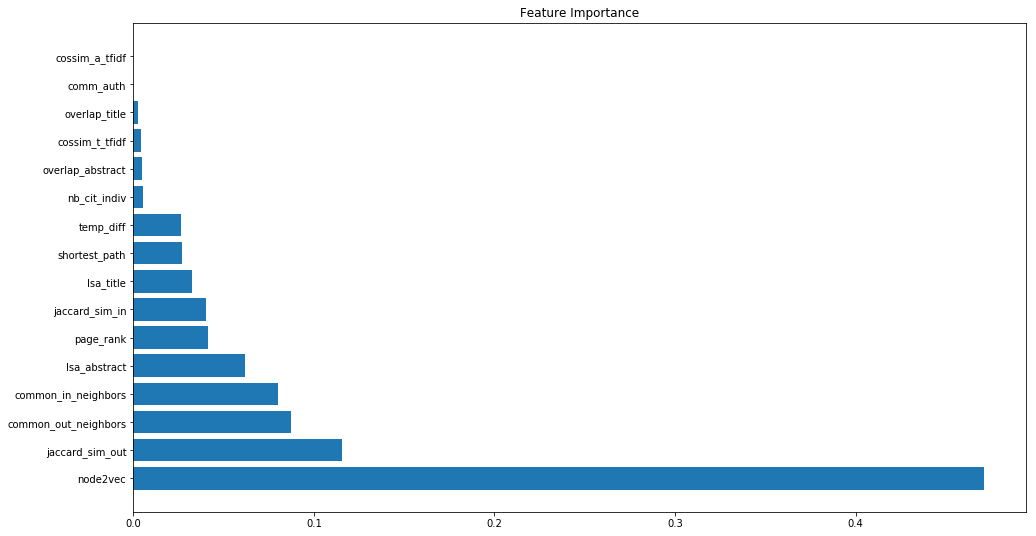

In [176]:
importance = list(features.values.reshape(-1))
bars = list(features.index.values)

y_pos = np.arange(len(bars))
 
fig, ax = plt.subplots(figsize=(16,9))

# Create horizontal bars
plt.barh(y_pos, importance)
 
# Create names on the y-axis
plt.yticks(y_pos, bars)

# Add title
plt.title('Feature Importance')

# Show graphic
plt.show()

---
## Model Comparison

In [173]:
tps0=time.clock()

# Classifiers
rf   = RandomForestClassifier()
gbm = GradientBoostingClassifier()
boost = xgb.XGBClassifier()
svm_  = SVC()
logi = LogisticRegression()
nnet=MLPClassifier()
nb = GaussianNB()

# Number of iterations
B=10 # to test the loop : use B=3 instead

# Parameters grids

listMethGrid=[logi,nb, svm_,rf,gbm,boost,nnet]
arrayErreur=np.empty((B,7))

In [205]:
for i in range(B):
    print(i)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
    
    # Computation of test error
    for j,method in enumerate(listMethGrid):
        methFit=method.fit(X_train, y_train)
        predictions = methFit.predict(X_test)
        arrayErreur[i,j]=f1_score(y_test, predictions)
        
tps1=time.clock()
print("Execution time in mn :",(tps1 - tps0)/60)

dataframeErreur=pd.DataFrame(arrayErreur,columns=["Logit","NB","SVM","RF","GBM","XGB","NNET"])    

0
1
2
3
4
5
6
7
8
9
Execution time in mn : 17.592656283333334


Text(0.5, 1.0, 'F1 Score')

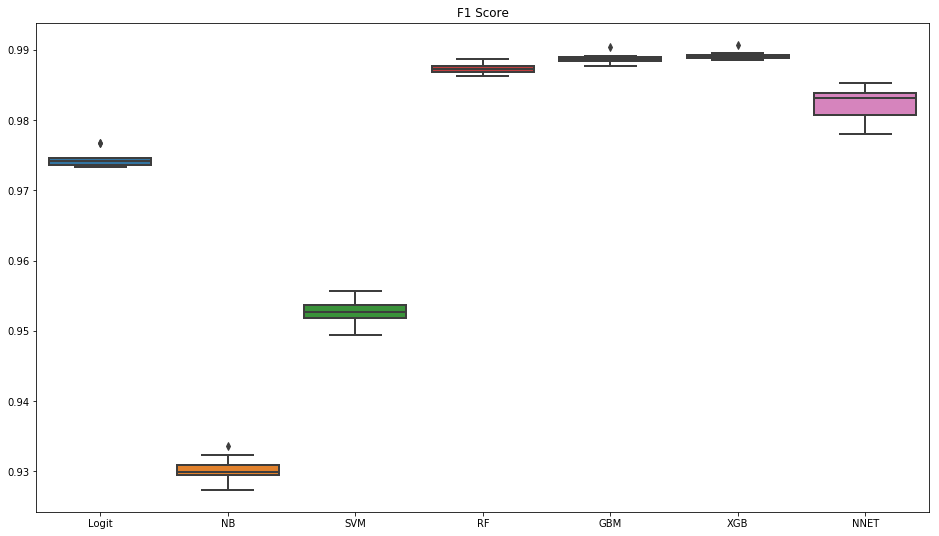

In [206]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(16,9))
x = list(dataframeErreur.columns.values) * 10
y = list(dataframeErreur.values.reshape(-1))
sns.boxplot(x=x, y=y, linewidth=2)
plt.title("F1 Score")

---
## Fine tuning
(TBD)

---
## Prediction

In [145]:
col= ['IDPairs','Edge']
colnames=[i for i in dataset.columns if i not in col]

In [146]:
model = GradientBoostingClassifier()
model = model.fit(X_train, y_train)
test=dataset_test[colnames]
predictions = model.predict(test)

In [147]:
final_pred = pd.concat([dataset_test['IDPairs'],pd.DataFrame(predictions)],axis=1)
final_pred.columns = ['id','category']
final_pred.to_csv('../Data/my_pred.csv',index=None)

---
## Save dataset

In [207]:
dataset.to_csv('../Data/dataset.csv', sep=',')
dataset_test.to_csv('../Data/dataset_test.csv', sep=',')